In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
sys.path.append('./../')
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('./../data/raw/btcusdt.csv')
from models.grid_bot import GridBot

In [133]:
class GridBot:
    def __init__(self, levels_num=10, balance=100000, levels_step=0.001, fee=0.002181, part=5, use_up=False):
        assert 0 < levels_step < 1, f'levels_step must be in (0, 1) range, {levels_step}'
        assert levels_num >= 1, f'levels_num must be greater than 0, {levels_num}'

        self.levels_num = levels_num
        self.levels_step = levels_step
        self.balance = balance
        self.history = []
        self.ref_price = None
        self.buy_orders = []
        self.sell_orders = []
        self.fee = fee
        self.buy_points = []
        self.sell_points = []
        self.use_up = use_up
        self.assets_list = []
        self.part = part
        self.bought = [False for _ in range(self.levels_num)]

    def trade(self, df_path):
        df = pd.read_csv(df_path)
        # use_mean - use mean price over last month as a ref level, else use first open price
        ref_price = df.iloc[0]['Open']
        self.ref_price = ref_price
        buy_orders = [ref_price * (1 - k * self.levels_step) for k in range(1, self.levels_num + 1)]
        if self.use_up:
            sell_orders = [ref_price * (1 + k * self.levels_step) for k in range(self.levels_num)]
        else:
            sell_orders = [ref_price * (1 - k * self.levels_step) for k in range(self.levels_num)]
        self.buy_orders = buy_orders
        self.sell_orders = sell_orders
        
        for index, row in tqdm(df.iterrows()):

            for i in range(len(self.bought)):
                if self.bought[i] and row.High >= sell_orders[i]:
                    self.bought[i] = False
                    self.balance += (self.assets_list[-1] * sell_orders[i] -self.assets_list[-1] * sell_orders[i] * self.fee)
                    del self.assets_list[-1]
                    self.history += [self.balance]
                    self.sell_points += [(index, sell_orders[i])]
                    
                elif not self.bought[i] and row.Low <= buy_orders[i] and self.balance >= (self.balance / self.part):
                    self.bought[i] = True
                    self.balance -= (self.balance / self.part + self.fee * self.balance / self.part)
                    self.history += [self.balance]
                    self.buy_points += [(index, buy_orders[i])]
                    self.assets_list += [(self.balance/ self.part- self.fee * self.balance / self.part) / buy_orders[i]]

        return self
                    
                    
    def plot(self, df_path):
        df = pd.read_csv(df_path)
        self = self.trade(df_path)
        plt.figure(figsize=(24,8))
        plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
             linewidth=1, markersize=1)

        plt.plot(df.index, [self.ref_price for i in df.index ], color='blue', linewidth=3, label='ref')
        plt.plot(df.index, [self.buy_orders for i in df.index ], color ='green', linewidth =0.5, linestyle='--' )
        plt.plot(df.index, [self.sell_orders for i in df.index ] , color ='red', linewidth =0.5, linestyle='--')

        plt.plot([i[0] for i in self.sell_points], [i[1] for i in self.sell_points] , 'ro', linewidth =2)
        plt.plot([i[0] for i in self.buy_points], [i[1] for i in self.buy_points] , 'go', linewidth =2)

        plt.legend()
        plt.show()
                    

# grid_bot = GridBot()
# grid_bot.trade('data/raw/btcusdt.csv')
# print(grid_bot.balance)
# print(grid_bot.history)


In [136]:
grid_bot = GridBot(levels_num=10, balance=100000, use_up = True, part=20, levels_step=0.001)
grid_bot.trade('./../data/raw/btcusdt.csv')
print(grid_bot.balance)

4321it [00:00, 16890.25it/s]

90335.04662687998


In [131]:
grid_bot.assets_list

[]

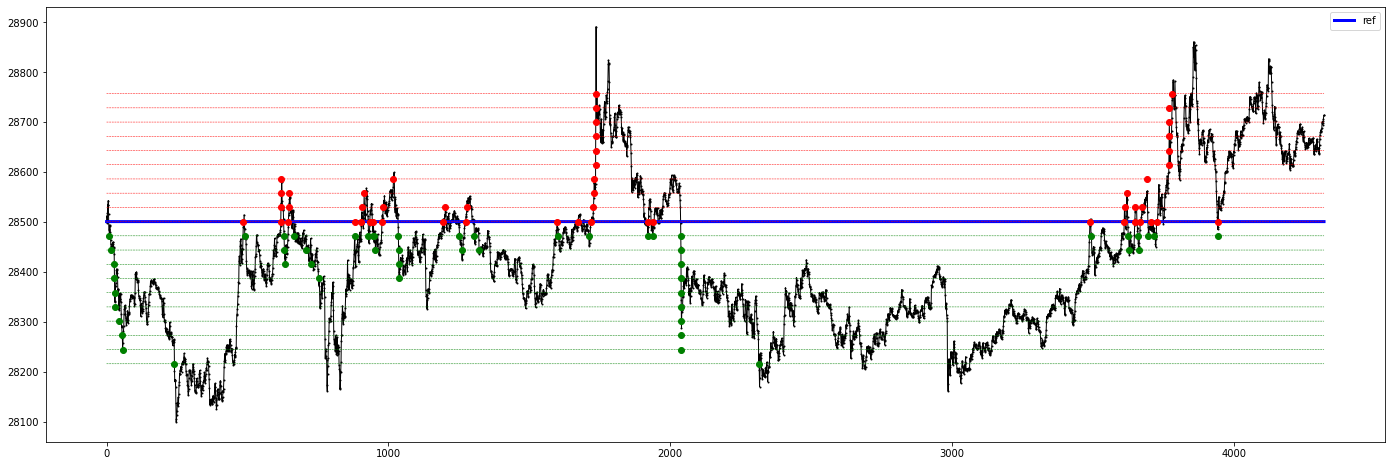

In [132]:
plt.figure(figsize=(24,8))
plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
     linewidth=1, markersize=1)

plt.plot(df.index, [grid_bot.ref_price for i in df.index ], color='blue', linewidth=3, label='ref')
plt.plot(df.index, [grid_bot.buy_orders for i in df.index ], color ='green', linewidth =0.5, linestyle='--' )
plt.plot(df.index, [grid_bot.sell_orders for i in df.index ] , color ='red', linewidth =0.5, linestyle='--')

plt.plot([i[0] for i in grid_bot.sell_points], [i[1] for i in grid_bot.sell_points] , 'ro', linewidth =2)
plt.plot([i[0] for i in grid_bot.buy_points], [i[1] for i in grid_bot.buy_points] , 'go', linewidth =2)

plt.legend()
plt.show()

4321it [00:00, 16320.37it/s]


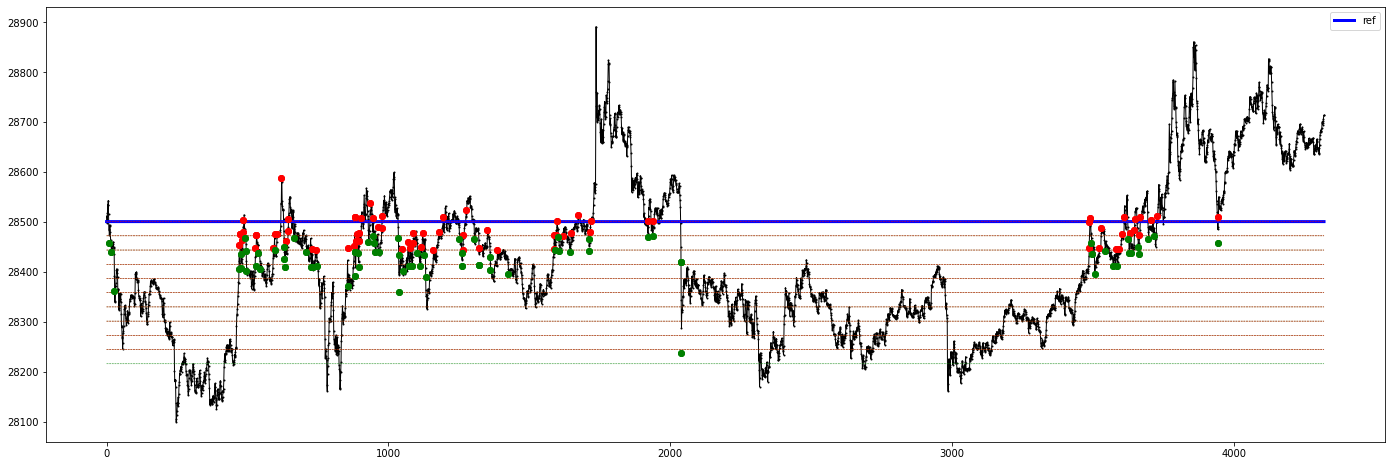

In [5]:
grid_bot.plot('./../data/raw/btcusdt.csv')

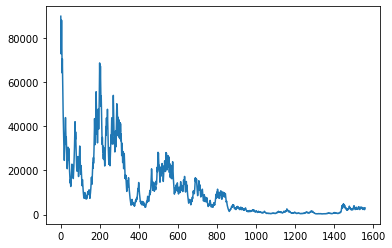

In [119]:
plt.plot(grid_bot.history)